### Importing Data

In [1]:
%%bash
pip install gdown
if [ ! -f census_income.zip ]; then
    gdown 1-PECcHuWo6wO3g6xbR2sOLOyoCWshfLS
fi
unzip -n census_income.zip

Couldn't find program: 'bash'


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

In [3]:
text_rdd = spark.sparkContext.textFile('adult100k')
text_rdd_cleaned = text_rdd.map(lambda x: tuple(x.split(',')))

In [4]:
schema = StructType([
    StructField("Age", StringType(), True),  
    StructField("WorkClass", StringType(), True),
    StructField("Fnlwgt", StringType(), True),
    StructField("Education", StringType(), True),
    StructField("EducationNum", StringType(), True),
    StructField("MaritalStatus", StringType(), True),
    StructField("Occupation", StringType(), True),
    StructField("Relationship", StringType(), True),
    StructField("Race", StringType(), True),
    StructField("Sex", StringType(), True),
    StructField("CapitalGain", StringType(), True),
    StructField("CapitalLoss", StringType(), True),
    StructField("HoursPerWeek", StringType(), True),
    StructField("NativeCountry", StringType(), True),
    StructField("Income", StringType(), True)
])

spark_dataframe = spark.createDataFrame(text_rdd_cleaned, schema)

In [5]:
spark_dataframe.show(5)

+---+----------------+------+---------+------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
|Age|       WorkClass|Fnlwgt|Education|EducationNum|     MaritalStatus|       Occupation| Relationship| Race|   Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|
+---+----------------+------+---------+------------+------------------+-----------------+-------------+-----+------+-----------+-----------+------------+-------------+------+
| 39|       State-gov| 77516|Bachelors|          13|     Never-married|     Adm-clerical|Not-in-family|White|  Male|       2174|          0|          40|United-States| <=50K|
| 50|Self-emp-not-inc| 83311|Bachelors|          13|Married-civ-spouse|  Exec-managerial|      Husband|White|  Male|          0|          0|          13|United-States| <=50K|
| 38|         Private|215646|  HS-grad|           9|          Divorced|Handlers-cleaners|Not-in-family|White|  Male|         

### Data Exploration 

In [6]:
# How many records in this dataframe? 
num_records = spark_dataframe.count()
print('Number of records:', num_records)

Number of records: 100000


In [7]:
# Data Type Handling 
NumericalDataType = ['Age', 'Fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']

for col_name in NumericalDataType:
    spark_dataframe = spark_dataframe.withColumn(col_name, col(col_name).cast('float'))

In [8]:
# Missing Data / Imputations 
null_counts = spark_dataframe.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in spark_dataframe.columns))
null_counts.show()

+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+
|Age|WorkClass|Fnlwgt|Education|EducationNum|MaritalStatus|Occupation|Relationship|Race|Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|
+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+
|  0|        0|     0|        0|           0|            0|         0|           0|   0|  0|          0|          0|           0|            0|     0|
+---+---------+------+---------+------------+-------------+----------+------------+----+---+-----------+-----------+------------+-------------+------+



In [9]:
# Describe the Data
spark_dataframe.describe()

DataFrame[summary: string, Age: string, WorkClass: string, Fnlwgt: string, Education: string, EducationNum: string, MaritalStatus: string, Occupation: string, Relationship: string, Race: string, Sex: string, CapitalGain: string, CapitalLoss: string, HoursPerWeek: string, NativeCountry: string, Income: string]

#### Column Descriptions 
- Age : Age of person in years (Numerical)
- WorkClass : Type of work that the person does (Catergorical)
- Fnlwgt : Final weight is the number of people the census believes the entry represents. (Numerical)
- Education : Highest Level of Education (Catergorical)
- EducationNum : Number of years completed of education (Numerical) 
- MaritalStatus : Marital status of the person (Catergorical)
- Occupation : Person's profession (Catergorical) 
- Relationship : Familial status of the person (Catergorical)
- Race : Race of person (Catergorical)
- Sex : Sex of person (Catergorical)
- CapitalGain : Capital gains for an individual (Numerical)
- CapitalLoss :  Capital loss for an individual (Numerical)
- HoursPerWeek : Hours per week that the person works (Numerical) 
- NativeCountry : Country of origin for an individual (Catergorical) 
- Income : Whether or not the person makes over or under $50k (Catergorical) 

### Data Visualization

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
sampled_df = spark_dataframe.sample(withReplacement = False, fraction = 0.001, seed = 505)
sampled_df.count()

94

In [12]:
sampled_df.show(5)

+----+---------+--------+------------+------------+------------------+---------------+--------------+-----+------+-----------+-----------+------------+-------------+------+
| Age|WorkClass|  Fnlwgt|   Education|EducationNum|     MaritalStatus|     Occupation|  Relationship| Race|   Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|
+----+---------+--------+------------+------------+------------------+---------------+--------------+-----+------+-----------+-----------+------------+-------------+------+
|43.0|  Private|174575.0|   Bachelors|        13.0|          Divorced|Exec-managerial| Not-in-family|White|  Male|        0.0|     1564.0|        45.0|United-States|  >50K|
|19.0|  Private|232392.0|     HS-grad|         9.0|     Never-married|  Other-service|Other-relative|White|Female|        0.0|        0.0|        40.0|United-States| <=50K|
|42.0|        ?|184018.0|Some-college|        10.0|          Divorced|              ?|     Unmarried|White|  Male|        0.0|        0

#### Numerical Variables

In [13]:
numerical_columns = ['Age', 'Fnlwgt', 'EducationNum', 'CapitalGain', 'CapitalLoss', 'HoursPerWeek']

In [14]:
pandas_df = sampled_df.select(numerical_columns).toPandas()

In [15]:
# Display basic statistics of numerical columns
print("Basic Statistics of Numerical Columns:")
print(pandas_df.describe())

Basic Statistics of Numerical Columns:
             Age         Fnlwgt  EducationNum   CapitalGain  CapitalLoss  \
count  94.000000      94.000000     94.000000     94.000000    94.000000   
mean   46.457447  185605.468750      9.170213   3707.436279  1384.744629   
std    21.961191  110723.367188      3.641571   5435.613281  1082.454224   
min    17.000000   21174.000000      2.000000      0.000000     0.000000   
25%    27.000000  118616.750000      7.000000      0.000000     0.000000   
50%    42.500000  175376.500000      9.000000   2338.500000  1602.000000   
75%    66.000000  226708.500000     12.000000   4584.000000  2195.500000   
max    87.000000  651396.000000     16.000000  25236.000000  4356.000000   

       HoursPerWeek  
count     94.000000  
mean      43.553192  
std       23.012674  
min        1.000000  
25%       30.500000  
50%       40.000000  
75%       56.500000  
max       99.000000  


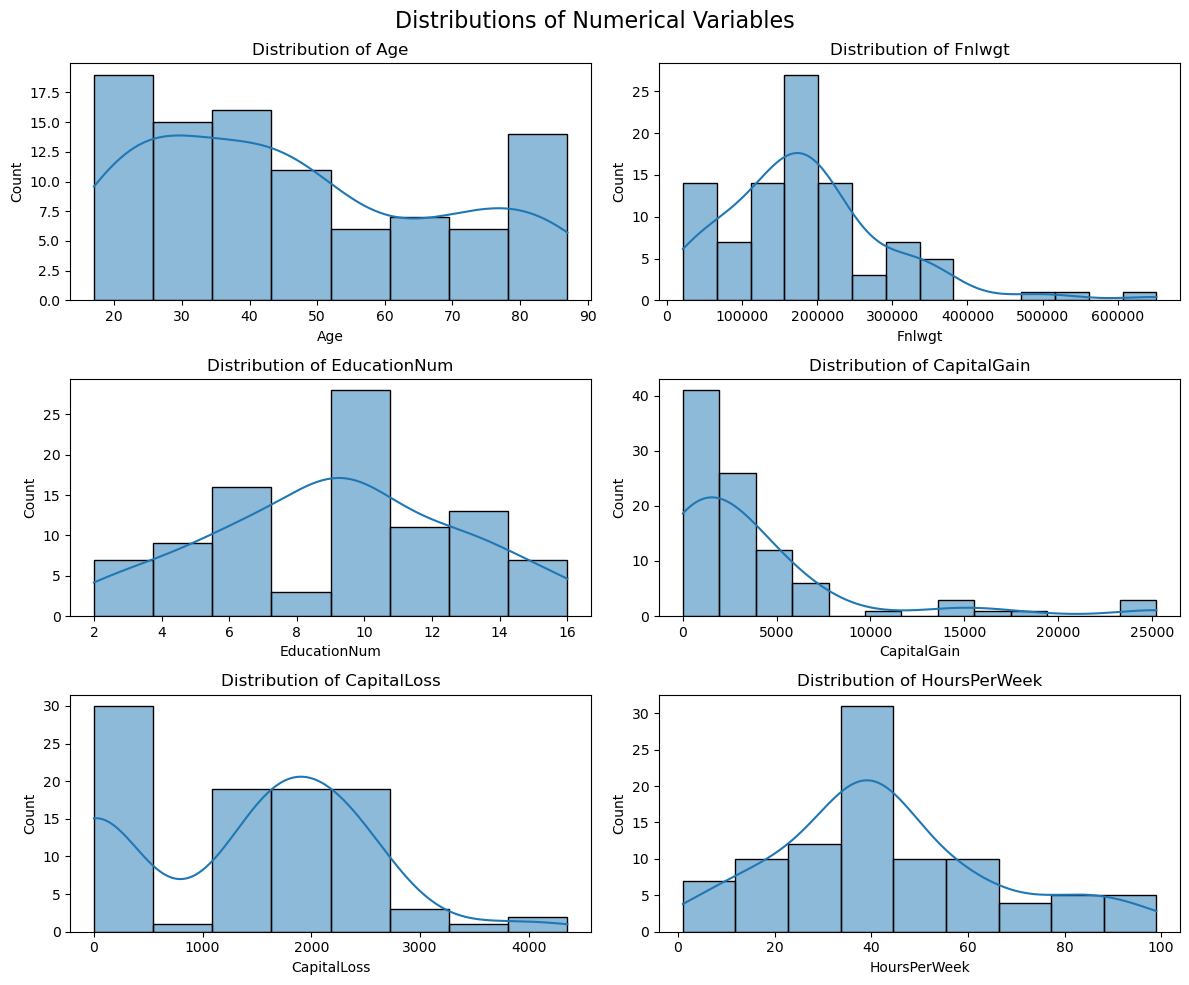

In [16]:
# Visualize the distribution of numerical columns in a 3 by 2 grid layout
plt.figure(figsize=(12, 10))
plt.suptitle("Distributions of Numerical Variables", fontsize=16)  # Title of the overall plot

for i, column in enumerate(pandas_df[numerical_columns]):
    plt.subplot(3, 2, i + 1)
    sns.histplot(pandas_df[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

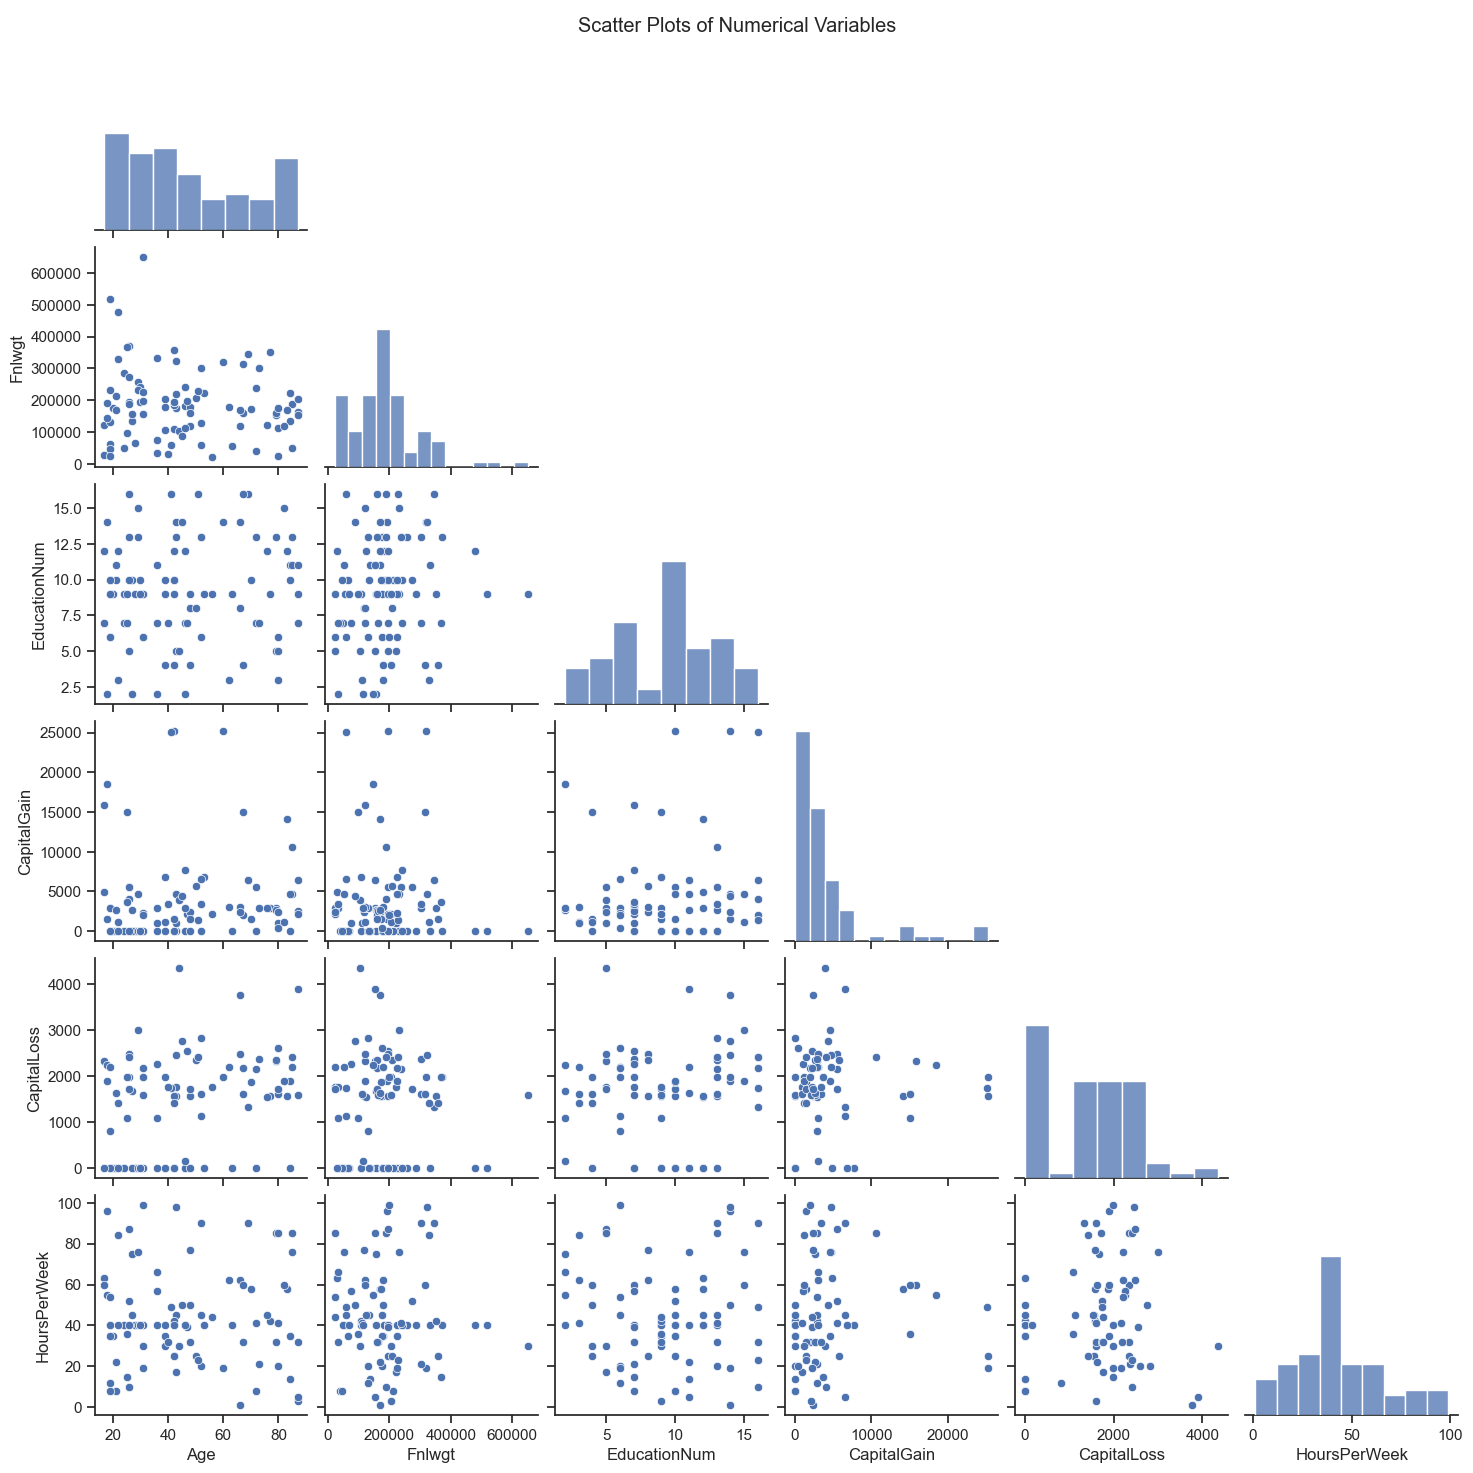

In [17]:
#Pairplot showing the scatter plots and relationships between Numerical Variables 
sns.set(style="ticks")

pp=sns.pairplot(pandas_df, corner='true' )
pp.fig.suptitle("Scatter Plots of Numerical Variables")
plt.show()

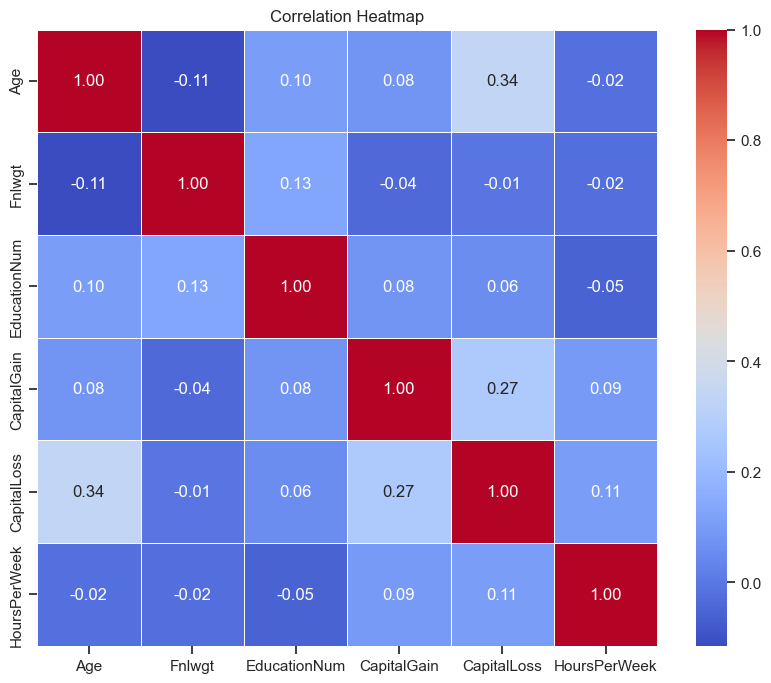

In [18]:
# Compute the correlation matrix
corr_matrix = pandas_df.corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, annot_kws={"size": 12})
plt.title('Correlation Heatmap')
plt.show()

#### Categorical Variables

In [19]:
categorical_columns = ['WorkClass', 'Education', 'MaritalStatus', 'Occupation', 'Relationship', 'Race', 'Sex', 'Income']
categorical_columns2 = ['NativeCountry']

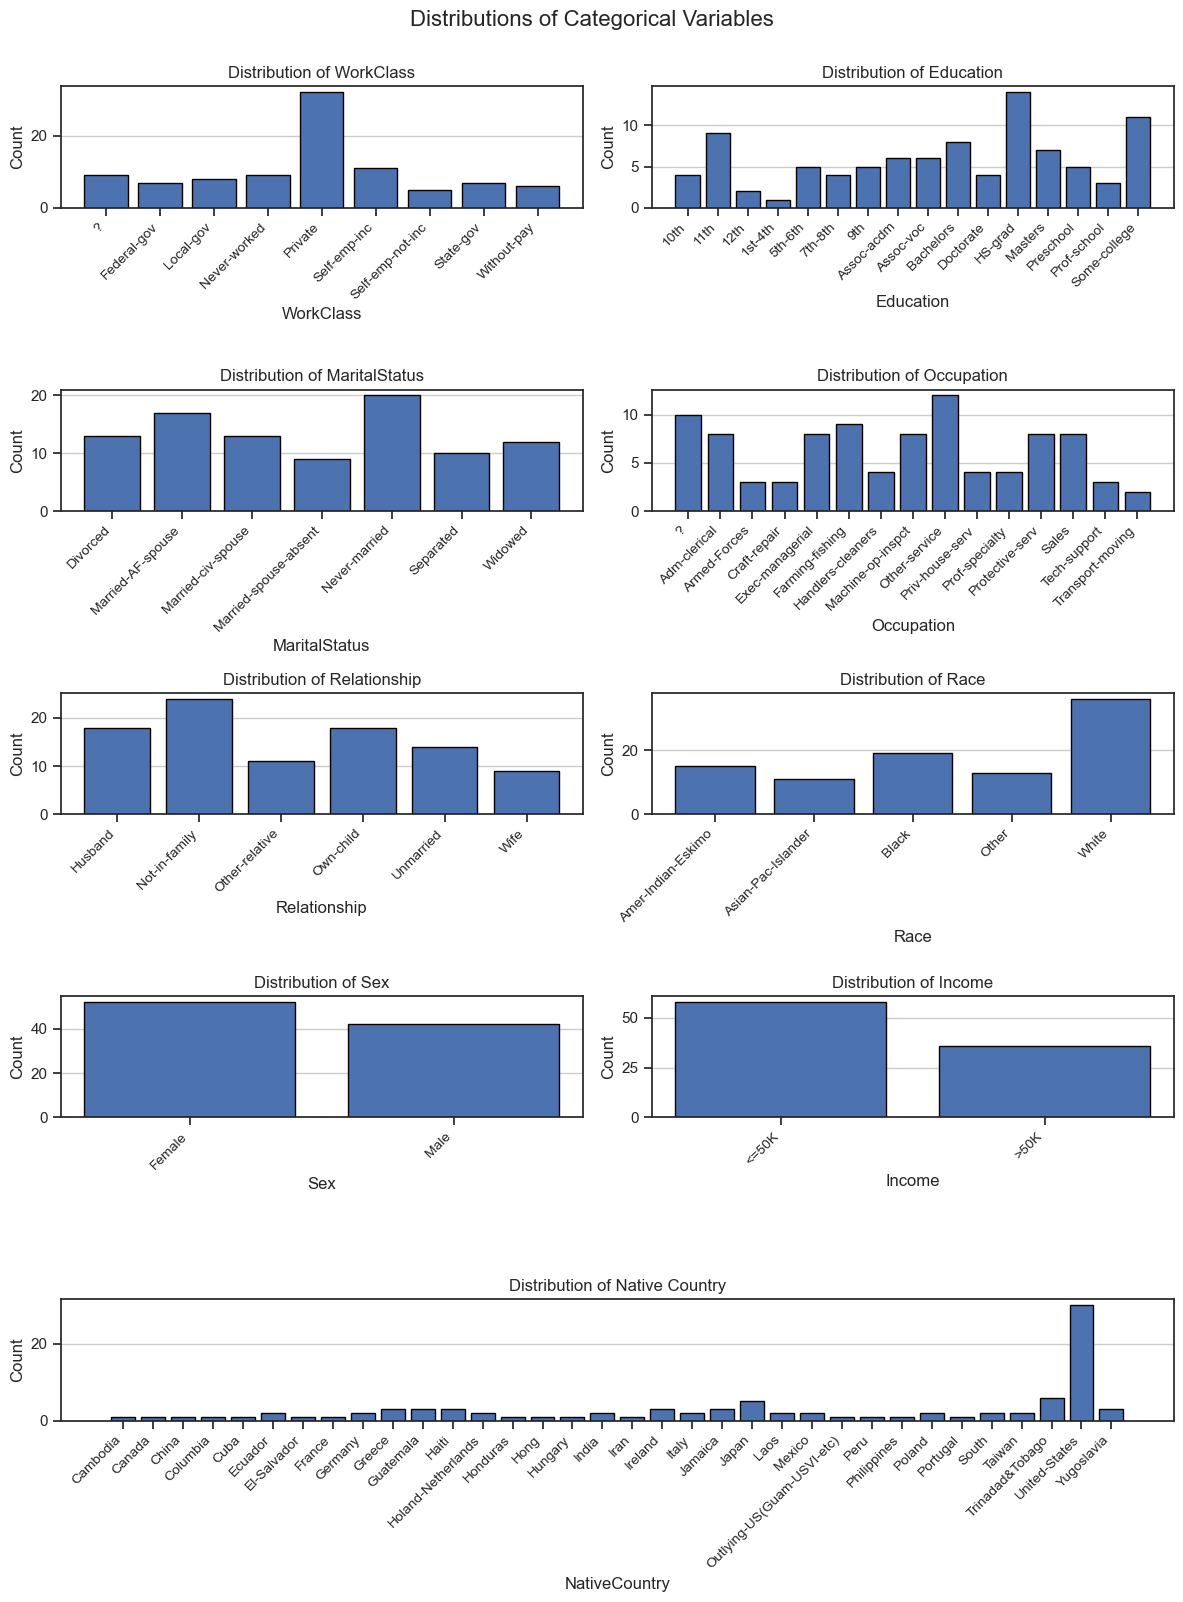

In [20]:
# Create subplots with a 4x2 grid for the categorical columns
fig, axes = plt.subplots(5, 2, figsize=(12, 16))
fig.suptitle("Distributions of Categorical Variables", fontsize=16, y=1)

# Plot bar plots for each categorical column
for i, col in enumerate(categorical_columns):
    counts = sampled_df.groupBy(col).count().orderBy(col).collect()
    categories = [str(row[col]) for row in counts]
    values = [row['count'] for row in counts]
    
    # Access the individual axes correctly
    ax = axes[i // 2, i % 2]
    ax.bar(categories, values, edgecolor='black')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
    ax.grid(axis='y')
    
    # Set ticks and then rotate x-axis labels by 45 degrees and increase font size
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=10)

# Plot bar plot for NativeCountry separately
counts2 = sampled_df.groupBy('NativeCountry').count().orderBy('NativeCountry').collect()
categories2 = [str(row['NativeCountry']) for row in counts2]
values2 = [row['count'] for row in counts2]

# Add a long horizontal graph at the bottom for NativeCountry
ax_bottom = plt.subplot2grid((5, 2), (4, 0), colspan=2)
ax_bottom.bar(categories2, values2, edgecolor='black')
ax_bottom.set_title('Distribution of Native Country')
ax_bottom.set_xlabel('NativeCountry')
ax_bottom.set_ylabel('Count')
ax_bottom.grid(axis='y')
ax_bottom.set_xticks(range(len(categories2)))
ax_bottom.set_xticklabels(categories2, rotation=45, ha='right', fontsize=10)

# Hide the empty subplots behind ax_bottom
for ax in axes[-1]:
    ax.set_visible(False)

# Adjust padding between subplots
plt.subplots_adjust(hspace=2)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

#### Response Variables

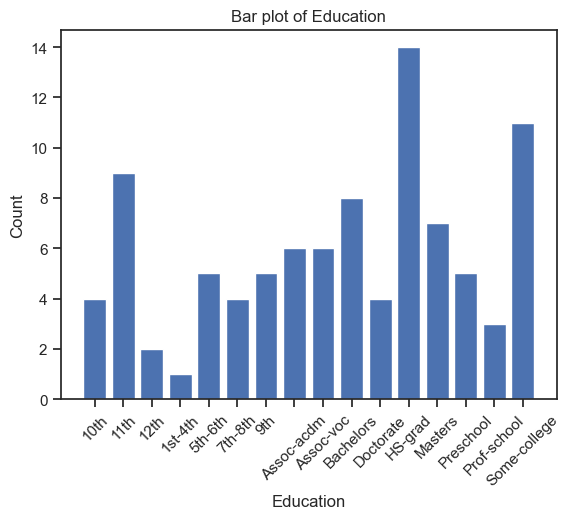

In [21]:
for i in ['Education']:
    value_counts = sampled_df.groupBy(i).count().orderBy(i).collect()

    values = [row[i] for row in value_counts]
    frequencies = [row['count'] for row in value_counts]

    plt.bar(values, frequencies)
    plt.xlabel(i)
    plt.ylabel('Count')
    plt.title('Bar plot of {}'.format(i))
    plt.xticks(rotation=45)
    plt.show()

In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define a function to map education levels to groups
def group_education_level(education_label):
    education_index_mapping = {
        'HS-grad': 'High School or GED',
        'Some-college': 'Some College',
        'Bachelors': "Bachelor's Degree",
        'Masters': "Master's Degree",
        'Assoc-voc': "Associate's Degree",
        '11th': 'Less than High School',
        'Assoc-acdm': "Associate's Degree",
        '10th': 'Less than High School',
        '7th-8th': 'Less than High School',
        '9th': 'Less than High School',
        'Prof-school': "Master's Degree",
        '12th': 'Less than High School',
        'Doctorate': 'Doctorate',
        '5th-6th': 'Less than High School',
        'Preschool': 'Less than High School',
        '1st-4th': 'Less than High School'
    }
    return education_index_mapping.get(education_label, 'Other')

# Define a UDF to apply the function to each row of the DataFrame
group_education_udf = udf(group_education_level, StringType())

# Apply the UDF to create a new column for grouped education levels
spark_dataframe_with_grouped_education = spark_dataframe.withColumn('EducationGroup', group_education_udf(spark_dataframe['Education']))

sampled_df_with_grouped_education = spark_dataframe_with_grouped_education.sample(withReplacement = False, fraction = 0.001, seed = 505)

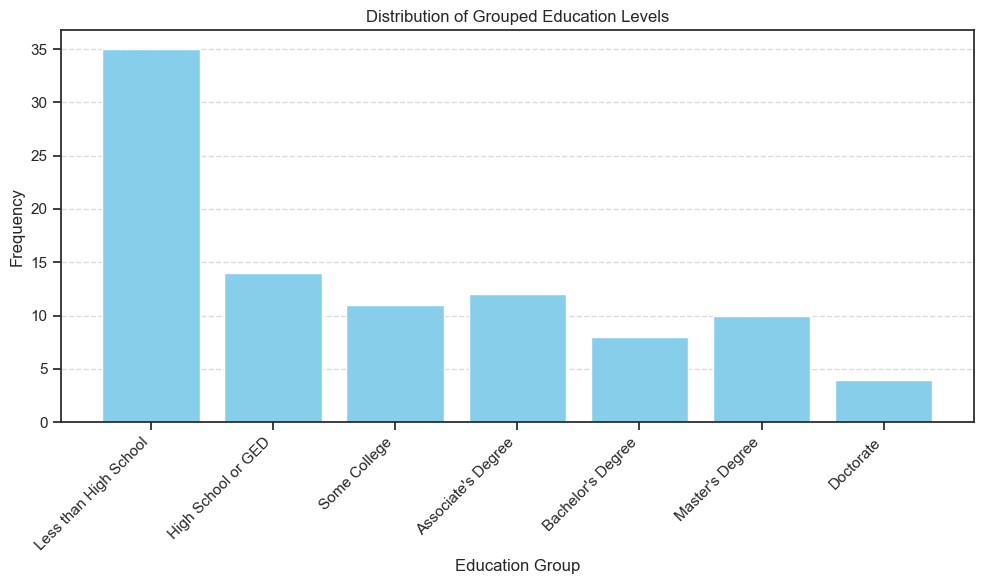

In [23]:
# Count the frequency of each education group
education_group_counts = sampled_df_with_grouped_education.groupBy('EducationGroup').count().toPandas()

# Define the order of education groups from least education to most education
education_order = [
    'Less than High School',
    'High School or GED',
    'Some College',
    "Associate's Degree",
    "Bachelor's Degree",
    "Master's Degree",
    'Doctorate',
    'Other'
]

# Filter only the existing education groups before reordering
existing_education_groups = [group for group in education_order if group in education_group_counts['EducationGroup'].values]

# Reorder the education_group_counts DataFrame based on the filtered order
education_group_counts = education_group_counts.set_index('EducationGroup').loc[existing_education_groups].reset_index()

# Plot the distribution of education groups
plt.figure(figsize=(10, 6))
plt.bar(education_group_counts['EducationGroup'], education_group_counts['count'], color='skyblue')
plt.title('Distribution of Grouped Education Levels')
plt.xlabel('Education Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [24]:
spark_dataframe_with_grouped_education = spark_dataframe_with_grouped_education.drop('Education')

In [25]:
# Print the schema of the DataFrame to check for the presence of the 'EducationGroup' column
spark_dataframe_with_grouped_education.printSchema()

root
 |-- Age: float (nullable = true)
 |-- WorkClass: string (nullable = true)
 |-- Fnlwgt: float (nullable = true)
 |-- EducationNum: float (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Relationship: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- CapitalGain: float (nullable = true)
 |-- CapitalLoss: float (nullable = true)
 |-- HoursPerWeek: float (nullable = true)
 |-- NativeCountry: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- EducationGroup: string (nullable = true)



## Data Preprocessing

- Numerical variables have been composed into a vector in `NumericalDataType` column
- Dataset has been split to train, test and validation set in proportions: 60/20/20
- Numerical variables vector have been scaled using `StandardScaler` to better represent normal distribution
- Categorical variables have been converted into their numerical representation
- Dataframes have been filtered to contain only transformed columnsumns

In [26]:
vector_assembler = VectorAssembler().setInputCols(NumericalDataType).setOutputCol('NumericalDataType')
spark_dataframe_transformed = vector_assembler.transform(spark_dataframe_with_grouped_education)

train_split, test_split, validation_split = spark_dataframe_transformed.randomSplit([0.6, 0.2, 0.2], seed=13)

scaler_model = StandardScaler().setInputCol('NumericalDataType').setOutputCol('NumericalDataTypeTransformed').fit(train_split)
scaled_train = scaler_model.transform(train_split)
scaled_test = scaler_model.transform(test_split)
scaled_validation = scaler_model.transform(validation_split)

scaled_train.show()

+----+---------+--------+------------+--------------------+-----------------+--------------+------------------+------+-----------+-----------+------------+-------------+------+--------------------+--------------------+----------------------------+
| Age|WorkClass|  Fnlwgt|EducationNum|       MaritalStatus|       Occupation|  Relationship|              Race|   Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|      EducationGroup|   NumericalDataType|NumericalDataTypeTransformed|
+----+---------+--------+------------+--------------------+-----------------+--------------+------------------+------+-----------+-----------+------------+-------------+------+--------------------+--------------------+----------------------------+
|17.0|        ?| 34019.0|         6.0|       Never-married|                ?|     Own-child|             White|  Male|        0.0|        0.0|        20.0|United-States| <=50K|Less than High Sc...|[17.0,34019.0,6.0...|        [0.84377759445743...|
|17.0|  

In [27]:
list_of_columns = list(spark_dataframe_with_grouped_education.columns)

CatergoricalDataType = [el for el in list_of_columns if el not in NumericalDataType]

In [28]:
string_indexer = StringIndexer(inputCols=CatergoricalDataType, outputCols=[el + "Indexed" for el in CatergoricalDataType])
indexer_model = string_indexer.fit(train_split)
indexed_train = indexer_model.transform(scaled_train)
indexed_test = indexer_model.transform(scaled_test)
indexed_validation = indexer_model.transform(scaled_validation)

indexed_train.show()

+----+---------+--------+------------+--------------------+-----------------+--------------+------------------+------+-----------+-----------+------------+-------------+------+--------------------+--------------------+----------------------------+----------------+--------------------+-----------------+-------------------+-----------+----------+--------------------+-------------+---------------------+
| Age|WorkClass|  Fnlwgt|EducationNum|       MaritalStatus|       Occupation|  Relationship|              Race|   Sex|CapitalGain|CapitalLoss|HoursPerWeek|NativeCountry|Income|      EducationGroup|   NumericalDataType|NumericalDataTypeTransformed|WorkClassIndexed|MaritalStatusIndexed|OccupationIndexed|RelationshipIndexed|RaceIndexed|SexIndexed|NativeCountryIndexed|IncomeIndexed|EducationGroupIndexed|
+----+---------+--------+------------+--------------------+-----------------+--------------+------------------+------+-----------+-----------+------------+-------------+------+----------------

In [29]:
preprocessed_columns = [el + "Indexed" for el in CatergoricalDataType] + ['NumericalDataTypeTransformed']
train = indexed_train.select(preprocessed_columns)
test = indexed_test.select(preprocessed_columns)
validation = indexed_validation.select(preprocessed_columns)

train.show()

+----------------+--------------------+-----------------+-------------------+-----------+----------+--------------------+-------------+---------------------+----------------------------+
|WorkClassIndexed|MaritalStatusIndexed|OccupationIndexed|RelationshipIndexed|RaceIndexed|SexIndexed|NativeCountryIndexed|IncomeIndexed|EducationGroupIndexed|NumericalDataTypeTransformed|
+----------------+--------------------+-----------------+-------------------+-----------+----------+--------------------+-------------+---------------------+----------------------------+
|             3.0|                 1.0|              7.0|                2.0|        0.0|       0.0|                 0.0|          0.0|                  0.0|        [0.84377759445743...|
|             3.0|                 1.0|              7.0|                2.0|        0.0|       1.0|                 0.0|          0.0|                  0.0|        [0.84377759445743...|
|             3.0|                 1.0|              7.0|        

In [30]:
# Features (X) for train, test, and validation
X_train = train.select(['WorkClassIndexed', 'MaritalStatusIndexed', 'OccupationIndexed', 'RelationshipIndexed', 'RaceIndexed', 'SexIndexed', 'NativeCountryIndexed', 'IncomeIndexed', 'NumericalDataTypeTransformed'])
X_test = test.select(['WorkClassIndexed', 'MaritalStatusIndexed', 'OccupationIndexed', 'RelationshipIndexed', 'RaceIndexed', 'SexIndexed', 'NativeCountryIndexed', 'IncomeIndexed', 'NumericalDataTypeTransformed'])
X_validation = validation.select(['WorkClassIndexed', 'MaritalStatusIndexed', 'OccupationIndexed', 'RelationshipIndexed', 'RaceIndexed', 'SexIndexed', 'NativeCountryIndexed', 'IncomeIndexed', 'NumericalDataTypeTransformed'])

# Target variable (y) for train, test, and validation
y_train = train.select('EducationGroupIndexed')
y_test = test.select('EducationGroupIndexed')
y_validation = validation.select('EducationGroupIndexed')

In [31]:
education_indexer_model = indexer_model 

# Retrieve the index mapping labels for the 'EducationGroup' column
educationgroup_mapping = education_indexer_model.labelsArray[8]  # 'Education' is the ninth indexed column

# Print the index mapping for the 'EducationGroup' column
print("Index mapping for 'EducationGroup' column:")
for index, label in enumerate(educationgroup_mapping):
    print(f"Index: {index} --> Label: {label}")


Index mapping for 'EducationGroup' column:
Index: 0 --> Label: Less than High School
Index: 1 --> Label: High School or GED
Index: 2 --> Label: Some College
Index: 3 --> Label: Associate's Degree
Index: 4 --> Label: Master's Degree
Index: 5 --> Label: Bachelor's Degree
Index: 6 --> Label: Doctorate


### Logistic Regression Model

In [32]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler

# Define the features (X) and target variable (y) columns
feature_columns = ['WorkClassIndexed', 'MaritalStatusIndexed', 'OccupationIndexed', 'RelationshipIndexed', 'RaceIndexed', 'SexIndexed', 'NativeCountryIndexed', 'IncomeIndexed', 'NumericalDataTypeTransformed']
label_column = 'EducationGroupIndexed'

# Define VectorAssembler to assemble features into a single vector column
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Create Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol=label_column)

# Create a pipeline with VectorAssembler and Logistic Regression model
pipeline = Pipeline(stages=[vector_assembler, lr])

# Fit the pipeline to the training data
model = pipeline.fit(train)

# Make predictions on the validation set
validation_predictions = model.transform(validation)

# Evaluate the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate accuracy on the validation set
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="EducationGroupIndexed", metricName="accuracy")
validation_accuracy = evaluator.evaluate(validation_predictions)
print("Validation Accuracy:", validation_accuracy)

Validation Accuracy: 0.4607058349695414


In [33]:
# Make predictions on the test set
test_predictions = model.transform(test)

accuracy = evaluator.evaluate(test_predictions)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.44939090819055166


### Fitting Graph

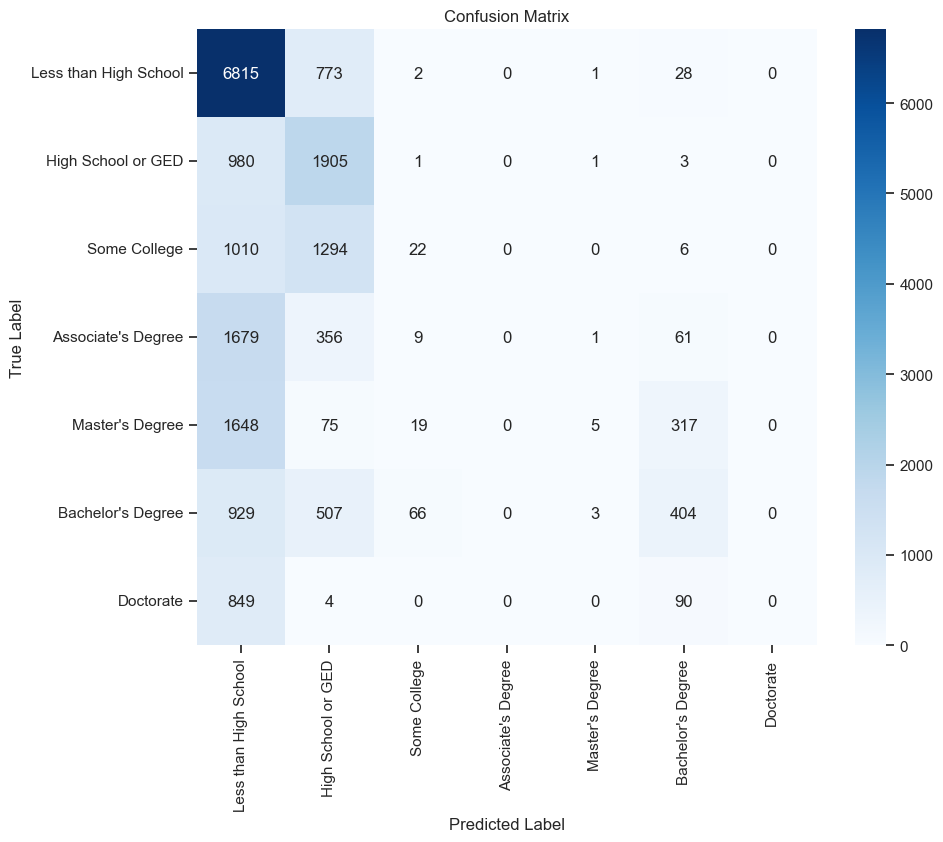

In [34]:
from sklearn.metrics import confusion_matrix

# Define education labels based on the provided mapping
education_labels = {
    0: 'Less than High School',
    1: 'High School or GED',
    2: 'Some College',
    3: "Associate's Degree",
    4: "Master's Degree",
    5: "Bachelor's Degree",
    6: 'Doctorate'
}

# Extract true and predicted labels from validation predictions
y_true = validation_predictions.select('EducationGroupIndexed').collect()
y_pred = validation_predictions.select('prediction').collect()

# Convert Spark DataFrame rows to lists
y_true = [row['EducationGroupIndexed'] for row in y_true]
y_pred = [row['prediction'] for row in y_pred]

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=education_labels.values(), yticklabels=education_labels.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### Data Download and Requirements

- Data can be downloaded off : https://www.kaggle.com/datasets/brijeshbmehta/adult-datasets